# im2latex(S): Data Binning

&copy; Copyright 2017 Sumeet S Singh

    This file is part of im2latex solution by Sumeet S Singh.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the Affero GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    Affero GNU General Public License for more details.

    You should have received a copy of the Affero GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

# What This Program Does
This notebook curates the [im2latex-100k dataset from Harvard NLP](https://zenodo.org/record/56198#.WT4fsxMrJE4) from a [Harvard NLP project](http://lstm.seas.harvard.edu/latex/) generated using [their code]( https://github.com/Miffyli/im2latex-dataset).

* This notebook loads the data set which are png files generated using [textogif](https://www.fourmilab.ch/webtools/textogif/textogif.html) (via the abovementioned sourcecode)
* Checks and visualizes the data
* Curates the data - whitening etc.
* Converts it to numpy arrays and finally stores it as pickle files.

----
## 'Binning' Training Data by Markup Sequence Length
Next, we'll group the samples by length of the (tokenized) latex formulas. The idea is to standardize the sequence lengths to a small set of fixed lengths (by padding smaller neighboring sequences with a 'null' tokens at the end.). This will allow us to create equal length batches for RNN/LSTM training while minimizing wasted training cycles. The [Show, Attend and Tell paper](https://www.semanticscholar.org/paper/Show-Attend-and-Tell-Neural-Image-Caption-Generati-Xu-Ba/146f6f6ed688c905fb6e346ad02332efd5464616) suggests this approach. At every epoch, we'll randomly/uniformly draw batches from within each group. Then we'll randomize said batch-list and use it for the training epoch. At next epoch, we'll repeat the process. The larger our group-size, that much better randomness we'll get in the training sequence. However the downside of increasing group-size is more padding of sequence-lengths resulting in wasteful  (and worse; maybe even misleading) training cycles.

-----

In [1]:
from __future__ import print_function
import os
import numpy as np
from IPython.display import display, Image as ipImage
import PIL
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
pd.options.display.max_rows = 600
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
pd.options.display.width = 160
data_folder = '../data/generated2'
image_folder = os.path.join(data_folder,'formula_images')

In [3]:
df_pruned = pd.read_pickle(os.path.join(data_folder, 'df_pruned.pkl'))

In [4]:
df_pruned[['width', 'word2id_len', 'height']].corr()

,width,word2id_len,height
width,1.000000,0.789018,0.218565
word2id_len,0.789018,1.000000,0.377885
height,0.218565,0.377885,1.000000


From the above correlation table we can clearly see the impact of pruning the outlier sampples from our dataset: the correlation of word2id_len went up from ~0.69 (for dff_all) to ~0.79 (for df_pruned).

In [5]:
display(df_pruned.word2id_len.quantile((.85,.90,.95,.96,.97,.98,.985,.99,1.0)))

0.850     96.0
0.900    106.0
0.950    120.0
0.960    124.0
0.970    128.0
0.980    134.0
0.985    137.0
0.990    141.0
1.000    150.0
Name: word2id_len, dtype: float64

**Below is what the sequence length distribution looks like at this point**

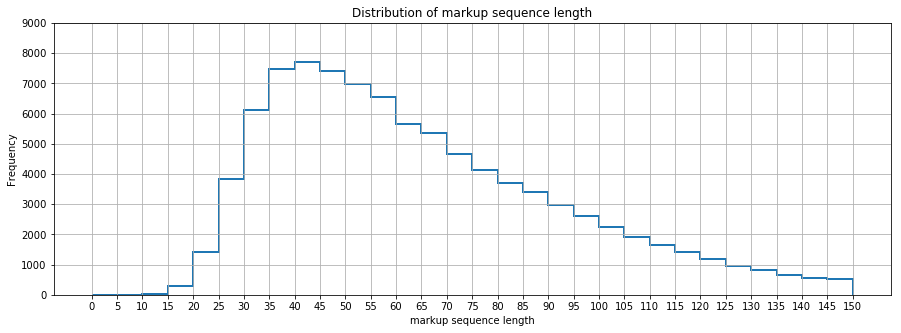

In [6]:
axes = plt.axes()
axes.set_xlabel('markup sequence length')
axes.set_title('Distribution of markup sequence length')
bins=range(0,151,5)
df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=bins, xticks=bins, yticks=range(0,9001,1000))

### Hyperparameter: Data Bins
Below we create the data-bins as described at the beginning of this section. This 'binning' is a training hyperparameter.

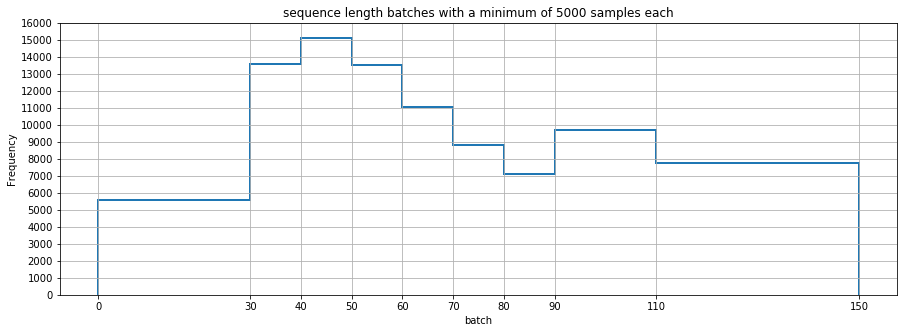

In [7]:
axes = plt.axes()
axes.set_xlabel('batch')
axes.set_ylabel('batch-count')
axes.set_title('sequence length batches with a minimum of 5000 samples each')
HYPER_bins=[0,30,40,50,60,70,80,90,110,150]
df_pruned.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=HYPER_bins, xticks=HYPER_bins, yticks=range(0,16001,1000))

In [8]:
## 'bin' the entries
labels=np.array(HYPER_bins[1:]) + 1 #Add 1 for ensuring minimum one 'null' token at the end of sequence.
## mapper for converting pandas category into integer
m = {}
for cat in range(len(labels)):
    m[cat] = labels[cat]
cats = pd.cut(df_pruned.word2id_len, HYPER_bins, labels=False)
df_bins = df_pruned.assign(bin_len=cats.map(m))[['image', 'height', 'width', 'word2id_len', 'bin_len', 'word2id', 'latex_ascii' ]]
df_bins.head()

,image,height,width,word2id_len,bin_len,word2id,latex_ascii
0,450f7c1496143fd_basic.png,78,738,112,151,"[257, 524, 552, 13, 212, 554, 523, 256, 1, 529, 537, 60, 26, 1, 552, 410, 1, 530, 554, 523, 552,...",\int_{-\epsilon}^\infty dl\: {\rm e}^{-l\zeta} \int_{-\epsilon}^\infty dl' {\rm e}^{-l'\zeta} ll...
1,868d5037af9e4b4_basic.png,94,962,125,151,"[529, 544, 523, 552, 18, 554, 1, 29, 1, 8, 17, 1, 13, 1, 552, 542, 528, 540, 544, 474, 364, 1, 5...",ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\the...
2,af0b6c3ee18804a_basic.png,87,291,47,51,"[517, 231, 524, 552, 410, 1, 533, 540, 541, 531, 554, 430, 454, 524, 552, 539, 30, 16, 554, 517,...",\widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\widetilde{G}_n{(-a)^n\over2^{2n-1}}\label{H4}
3,dda45eca6d32fa3_basic.png,35,405,53,61,"[8, 552, 159, 1, 44, 554, 524, 526, 1, 532, 9, 524, 552, 534, 535, 554, 1, 29, 1, 16, 12, 1, 60,...","({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H)_{ijk} = 0 ,"
4,67eb249ed1c20d2_basic.png,60,521,69,71,"[51, 524, 552, 544, 545, 526, 545, 554, 1, 29, 1, 18, 377, 1, 446, 552, 46, 524, 21, 523, 552, 8...",S_{stat} = 2\pi \sqrt{N_5^{(1)} N_5^{(2)} N_5^{(3)}} \left(\sqrt{n} +\sqrt{\bar{n}}\right)\label...


In [9]:
df_bins.groupby('bin_len').count()

,image,height,width,word2id_len,word2id,latex_ascii
bin_len,,,,,,
31,6608,6608,6608,6608,6608,6608
41,14032,14032,14032,14032,14032,14032
51,15042,15042,15042,15042,15042,15042
61,13341,13341,13341,13341,13341,13341
71,10858,10858,10858,10858,10858,10858
81,8598,8598,8598,8598,8598,8598
91,6900,6900,6900,6900,6900,6900
111,9480,9480,9480,9480,9480,9480
151,7424,7424,7424,7424,7424,7424


In [10]:
HYPER_batch_size = 128
test_count = int(df_bins.shape[0]*0.05 // HYPER_batch_size) * HYPER_batch_size
df_test = df_bins.sample(n=test_count)
df_train = df_bins.drop(df_test.index)
assert df_train.index.intersection(df_test.index).shape[0] == 0
print(df_bins.shape, df_test.shape, df_train.shape)
#df_test.to_pickle(os.path.join(data_folder,'training/df_test.pkl'))
#df_train.to_pickle(os.path.join(data_folder,'training/df_train.pkl'))

(92283, 7) (4608, 7) (87675, 7)


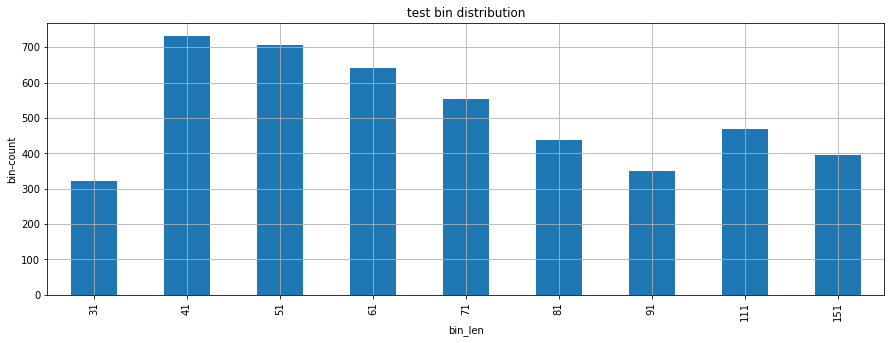

In [11]:
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('test bin distribution')
df_test.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

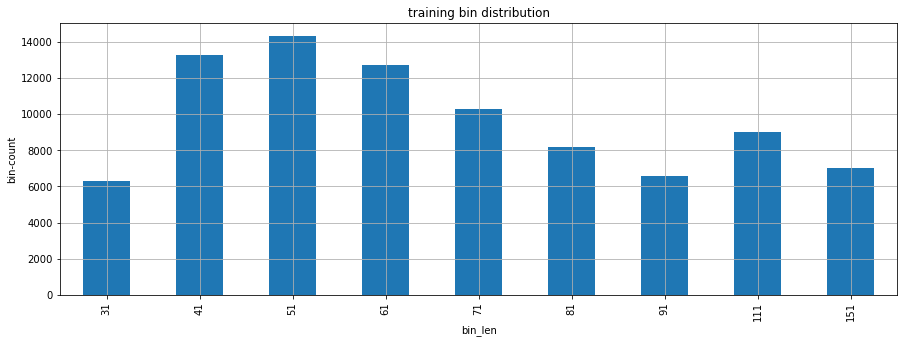

In [12]:
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('training bin distribution')
df_train.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

In [13]:
b_lens = (df_test.groupby('bin_len').count().index)
cs = df_test.groupby('bin_len').count().image.values.tolist()
cs[0]

323

In [14]:
## Code that adjusts bin-composition in order to minimze waste of samples owing to batch quantization
def print_bin_waste(df_, batch_size_):
    cum = 0
    bin_lens = sorted(df_.bin_len.unique().tolist())
    counts = [df_[df_.bin_len==l].shape[0] for l in bin_lens]
    total = sum(counts)
    for i in range(len(bin_lens)):
        rem = counts[i] % batch_size_
        cum += rem
        print("%d)\t%d,\t%d,\t%d"%(bin_lens[i], counts[i], rem, cum))
    assert total == sum(counts)
    print('total %% batch_size_ = %d'%(total%batch_size_,))
    return

def adjust_bins(df_bins_, batch_size_):
    df_ = df_bins_.copy()
    ## Idea is to spread the sample-waste over all the bins, proportional to the size of the bin.
    waste = df_.shape[0] % batch_size_
    bin_lens = sorted(df_.bin_len.unique().tolist())
    bin_counts = [df_[df_.bin_len==l].shape[0] for l in bin_lens]
    ## Draw from a multinomial distribution to get the number of samples to waste in each bin.
    pvals = np.array(bin_counts, dtype=float) / df_.shape[0]
    print(pvals, " sum=%f"%(sum(pvals),))
    bin_waste = np.random.multinomial(waste, pvals)
    print(bin_waste, " sum=%d"%(sum(bin_waste),))
    ## Now adjust the bins
    for i in range(len(bin_lens)-1):
        ## Can't use bin_count here because it changes during the loop
        rem = df_[df_.bin_len == bin_lens[i]].shape[0] % batch_size_ - bin_waste[i]
        if rem > 0:
            ## Move the tail of the bin into the next one
            df_slice = df_[df_.bin_len == bin_lens[i]].word2id_len.sort_values()[-1*rem:].index
            df_.loc[df_slice, 'bin_len'] = bin_lens[i+1]
            print('Moving %d samples from bin %d to %d'%(rem,bin_lens[i],bin_lens[i+1]))
        elif rem < 0:
            ## Move in the head of the next bin into this one
            df_slice = df_[df_.bin_len == bin_lens[i+1]].word2id_len.sort_values()[:-1*rem].index
            new_bin_len = df_.loc[df_slice].word2id_len.max() + 1
            print('Moving %d samples from bin %d to %d (old_bin_len = %d)'%(rem,bin_lens[i+1],new_bin_len,bin_lens[i]))
            df_.loc[df_slice, 'bin_len'] = new_bin_len
            df_.loc[df_.bin_len == bin_lens[i], 'bin_len'] = new_bin_len
            bin_lens[i] = new_bin_len
    print('Final bins: ', bin_lens)
    return df_

31)	6285,	13,	13
41)	13300,	116,	129
51)	14337,	1,	130
61)	12701,	29,	159
71)	10303,	63,	222
81)	8159,	95,	317
91)	6551,	23,	340
111)	9010,	50,	390
151)	7029,	117,	507
total % batch_size_ = 123
[ 0.0716852   0.15169661  0.16352438  0.14486456  0.11751354  0.0930596
  0.07471913  0.1027659   0.08017109]  sum=1.000000
[ 9 18 22 12 15  9  9 18 11]  sum=123
Moving 4 samples from bin 31 to 41
Moving 102 samples from bin 41 to 51
Moving 81 samples from bin 51 to 61
Moving 98 samples from bin 61 to 71
Moving 18 samples from bin 71 to 81
Moving 104 samples from bin 81 to 91
Moving 118 samples from bin 91 to 111
Moving 22 samples from bin 111 to 151
Final bins:  [31, 41, 51, 61, 71, 81, 91, 111, 151]
31)	6281,	9,	9
41)	13202,	18,	27
51)	14358,	22,	49
61)	12684,	12,	61
71)	10383,	15,	76
81)	8073,	9,	85
91)	6537,	9,	94
111)	9106,	18,	112
151)	7051,	11,	123
total % batch_size_ = 123


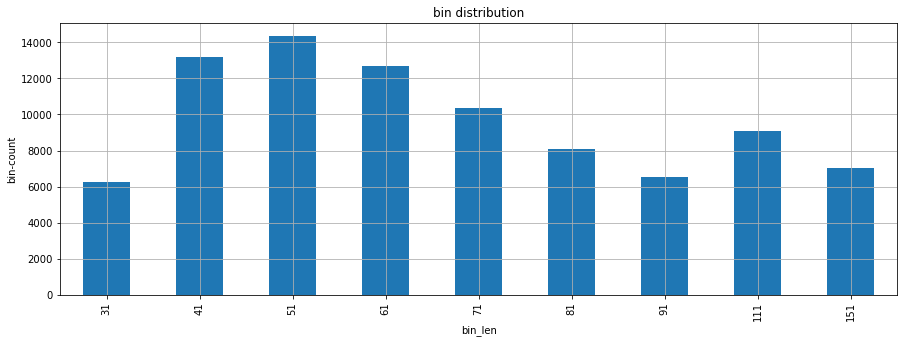

In [15]:
print_bin_waste(df_train, HYPER_batch_size)
df_train_adjusted = adjust_bins(df_train, HYPER_batch_size)
print_bin_waste(df_train_adjusted, HYPER_batch_size)
## Plot
axes = plt.axes()
axes.set_xlabel('bin_len')
axes.set_ylabel('bin-count')
axes.set_title('bin distribution')
df_train_adjusted.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

31)	323,	67,	67
41)	732,	92,	159
51)	705,	65,	224
61)	640,	0,	224
71)	555,	43,	267
81)	439,	55,	322
91)	349,	93,	415
111)	470,	86,	501
151)	395,	11,	512
total % batch_size_ = 0
[ 0.07009549  0.15885417  0.15299479  0.13888889  0.12044271  0.0952691
  0.07573785  0.10199653  0.08572049]  sum=1.000000
[0 0 0 0 0 0 0 0 0]  sum=0
Moving 67 samples from bin 31 to 41
Moving 31 samples from bin 41 to 51
Moving 96 samples from bin 51 to 61
Moving 96 samples from bin 61 to 71
Moving 11 samples from bin 71 to 81
Moving 66 samples from bin 81 to 91
Moving 31 samples from bin 91 to 111
Moving 117 samples from bin 111 to 151
Final bins:  [31, 41, 51, 61, 71, 81, 91, 111, 151]
31)	256,	0,	0
41)	768,	0,	0
51)	640,	0,	0
61)	640,	0,	0
71)	640,	0,	0
81)	384,	0,	0
91)	384,	0,	0
111)	384,	0,	0
151)	512,	0,	0
total % batch_size_ = 0


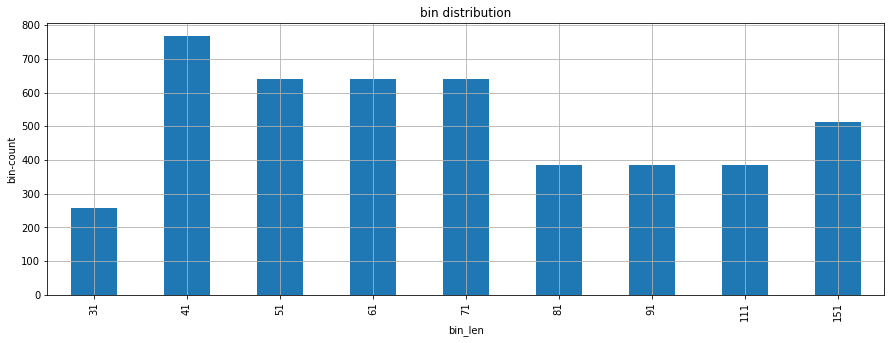

In [17]:
print_bin_waste(df_test, HYPER_batch_size)
df_test_adjusted = adjust_bins(df_test, HYPER_batch_size)
print_bin_waste(df_test_adjusted, HYPER_batch_size)
## Plot
axes = plt.axes()
axes.set_ylabel('bin-count')
axes.set_title('bin distribution')
df_test_adjusted.groupby('bin_len').count().image.plot.bar(ax=axes, lw=2, figsize=(15,5), grid=True)

In [18]:
#df_train_adjusted.to_pickle(os.path.join(data_folder, 'training/df_train_adjusted.pkl'))
#df_test_adjusted.to_pickle(os.path.join(data_folder, 'training/df_test_adjusted.pkl'))

In [22]:
def get_padded(df_):
    df = df_[['bin_len', 'word2id_len', 'word2id']]
    def pad(row_ar):
        """return null-terminated and padded token-sequence, padded upto bin_len size."""
        word2id = row_ar[2]
        ## plen = (pad_before, pad_after)
        plen = (0, row_ar[0]-row_ar[1])
        ## Ensure that we have room for at least one null-terminator
        assert plen[1] > 0
        return np.pad(word2id, plen, 'constant', constant_values=0).tolist()
    
    padded_seq = df.apply(pad, raw=True, reduce=True, axis=1)
    return df_.assign(seq_len=df_.word2id_len+1, padded_seq=padded_seq, padded_seq_len=padded_seq.str.len())

In [23]:
df_train_padded = get_padded(df_train_adjusted)
assert sum(df_train_padded.padded_seq_len != df_train_padded.bin_len) == 0
assert sum(df_train_padded.word2id_len != (df_train_padded.seq_len-1)) == 0
df_train_padded.to_pickle(os.path.join(data_folder, 'training/df_train.pkl'))

In [25]:
df_test_padded = get_padded(df_test_adjusted)
assert sum(df_test_padded.padded_seq_len != df_test_padded.bin_len) == 0
assert sum(df_test_padded.word2id_len != (df_test_padded.seq_len-1)) == 0
df_test_padded.to_pickle(os.path.join(data_folder, 'training/df_test.pkl'))

In [26]:
"""creates ndarrays of (padded) sequence bins from df_train_padded 
and pickles them as a dictionary of ndarrays wrapped in dataframes."""
def make_seq_bins(df_, data_dir_):
    bin_lens = df_.bin_len.unique()
    bins = {}
        
    for len_ in bin_lens:
        df_slice = df_[df_.padded_seq_len == len_]
        bin_ = np.array(df_slice.padded_seq.values.tolist(), dtype=np.int32)
        assert bin_.shape[1] == len_
        assert bin_.shape[0] == df_slice.shape[0]
        bins[len_] = pd.DataFrame(bin_, index=df_slice.index)
    return bins

bins_train = make_seq_bins(df_train_padded, data_folder)
## Persist to disk
raw_data_dir = os.path.join(data_folder, 'training')
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)
with open(os.path.join(raw_data_dir, 'raw_seq_train.pkl'), 'wb') as f:
  pickle.dump(bins, f, pickle.HIGHEST_PROTOCOL)
bins_test = make_seq_bins(df_test_padded, data_folder)
## Persist to disk
with open(os.path.join(raw_data_dir, 'raw_seq_test.pkl'), 'wb') as f:
  pickle.dump(bins, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def make_batch_list(data_dir_, batch_size_):
    df_train = pd.read_pickle(os.path.join(data_dir_, 'training/df_train.pkl'))
    batch_list = []
    for 
        